# Phonem Feature Extraction Detection 

This code have the purpose of perfomer phonem detection out of a voice recorder. 

In [208]:
import warnings

warnings.filterwarnings('ignore')

In [209]:
#Imports
import math
import librosa
import librosa.display
import IPython.display as ipd

import os
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


import numpy as np
import matplotlib.pyplot as plt

from numpy import sin, cos, pi, linspace, arange, log10, absolute
from numpy.random import randn
from scipy.signal import lfilter, lfilter_zi, filtfilt, butter, freqz, welch
from scipy.io.wavfile import read , write
from scipy.signal import spectrogram

# Load audio file and present their information

In [210]:
#Directorio do Projeto (Escrever o directório do projeto)
os.chdir(r'C:\Users\Dasil\1. Processamento Digital do Sinal\Project')
#os.chdir(r'C:/Users/lemos/PDS/TP/')

#Load one specific audio
filename = 'J_lata_01'
directory = 'Word Detection/training/' + filename + '.wav'

fs, audio1 = read(directory)
f,t,S1 = spectrogram(audio1, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')

#print information about the audio
print('filename: ', filename)
print('Data Length (s): ',t[-1])
print('Sampling frequency (samples/s): ', fs)

#Playing Audio (Reproduce Audio)
ipd.Audio(directory)

filename:  J_lata_01
Data Length (s):  5.25
Sampling frequency (samples/s):  44100


# Functions


In [211]:
#Cepstrum and Power Spectrum

def real_cepstrum(x, n=None):
# Compute the real cepstrum of a real sequence
#    x : ndarray
#        Real sequence to compute real cepstrum of.
#    n : {None, int}, optional
#        Length of the Fourier transform.
#    Returns
#    -------
#    ceps: ndarray
#        The real cepstrum.

    spectrum = np.abs(np.fft.fft(x, n=n))**2
    ceps = np.fft.ifft(np.log(spectrum))

    return ceps, spectrum

In [212]:
#Zero Crossing Rate

def ZCR(samples, frameSize, overlap):
    wlen = len(samples)
    step = frameSize - overlap
    frameNum = math.ceil(wlen/step)
    zcr = np.zeros((frameNum,1))
    for i in range(frameNum):
        curFrame = samples[np.arange(i*step,min(i*step+frameSize,wlen))]
        #To avoid DC bias, usually we need to perform mean substraction on each frame
        curFrame = curFrame - np.mean(curFrame) #Zero-Justified
        zcr[i] = sum(curFrame[0:-1]*curFrame[1::]<=0)
    return zcr

In [213]:
#Filtro ButterWorth

wn = 1500/(fs/2)
b3,a3 = butter(4, wn)
#Apply the filter
audio1_filt = lfilter(b3,a3,audio1)

# First Audio Segmentation

Separate the word from the rest of the data

# of chunks detected: 2
50316 95701
45385


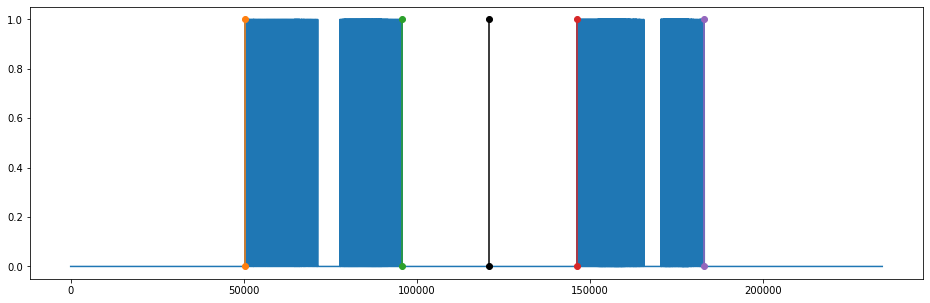

In [214]:
#Apply first threshold
results = [1 if item > 500 else 0 for item in audio1_filt]

# Variables
x1 = x2 = 0
flag = False
chunks = []
coordinates = []
zeros_list = []
silence_len = 10000
min_len = 10000

plt.plot(results)
for i, result in enumerate(results):
    # First signal rise
    if(flag == False and result == 1 and x1 == 0):
        flag = True
        x1 = i
    # Check if fall is permanent
    if(flag == True):
        if(result == 0):
            zeros_list.append(result)
        else:
            zeros_list = []
    # Signal fall
    if(flag == True and len(zeros_list) >= silence_len and x2 == 0):
        flag = False
        x2 = i - len(zeros_list)
        # If data is valid, save it in list
        if(not x2-x1 <= min_len):
            chunks.append(results[x1:x2+1])
            coordinates.append([x1, x2])
            plt.plot([x1, x1], [0, 1], [x2, x2], [0, 1], marker='o')
        # Reset to initial state
        x1 = x2 = 0

print(f'# of chunks detected: {len(chunks)}')

pt1 = coordinates[0]
try:
    pt2 = coordinates[1]
    div_ptn = ((pt2[0] - pt1[1]) / 2) + pt1[1]
except:
    div_ptn = ((pt1[1] + pt1[0]) / 2)
    
# Draw dividing line
plt.plot([div_ptn, div_ptn], [0, 1], marker='o', color="black")
print(pt1[0], pt1[1])
print(pt1[1] - pt1[0])

#Make segmentation point integer
div_ptn = round(div_ptn)

# Fix-sized segmentation (breaks a signal into non-overlapping segments)
signal = audio1 / (2**15)
signal_len = len(signal)
segment_size_t = 1 # segment size in seconds
segment_size = segment_size_t * fs  # segment size in samples

# Break signal into list of segments in a single-line Python code
segment1 = audio1[:div_ptn]
segment2 = audio1[div_ptn:]
segments = [segment1, segment2]

# Find out the number of Segments
n = len(segments)

# Process each chunk
# Save each segment in a seperate filename
for iS, s in enumerate(segments):
    write('Word Detection/PD_data/'+filename+'_{0:d}.wav'.format(segment_size_t * iS, segment_size_t * (iS + 1)), fs, (s))


# Word Selection for processing

In [199]:
#Load one specific word
directory = 'word Detection/PD_data/' + filename + '_1.wav'
print(directory)

# Read file path
fs, word = read(directory)

#fs, word = read(directory)
f,t,S1 = spectrogram(word, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')

#print information about the word
print('filename: ', filename)
print('Data Length (s): ',t[-1])
print('Sampling frequency (samples/s): ', fs)

#Playing word (Reproduce word)
ipd.Audio(word, rate = fs)

word Detection/PD_data/J_lata_01_1.wav
filename:  J_lata_01
Data Length (s):  2.5
Sampling frequency (samples/s):  44100


# Spectrogram 

Text(0, 0.5, 'frequency(Hz)')

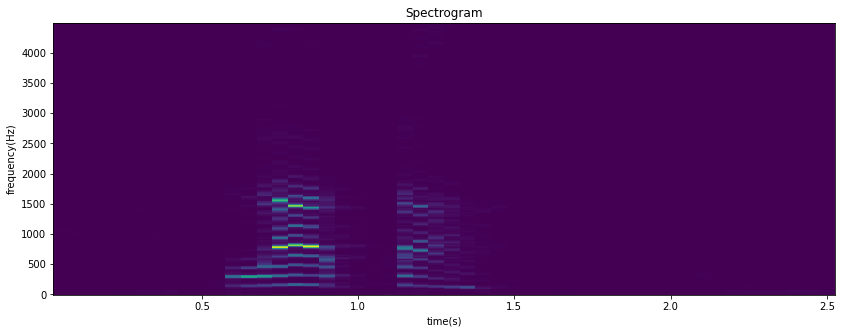

In [200]:
#Graphic Spectrogram 

plt.rcParams['figure.figsize'] = 14,5
plt.pcolormesh(t, f[:450], S1[:450][:])
plt.title("Spectrogram")
plt.xlabel('time(s)')
plt.ylabel('frequency(Hz)')

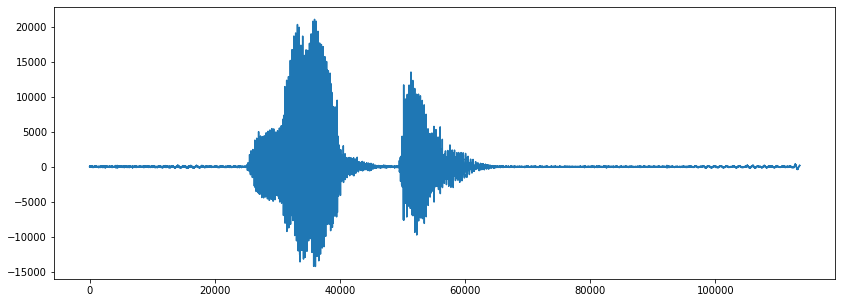

In [201]:
#Filtro ButterWorth

wn = 1500/(fs/2)
b3,a3 = butter(4, wn)
#Apply the filter
word_filt = lfilter(b3,a3,word)

plt.plot(word_filt)

# Show Word Filtered

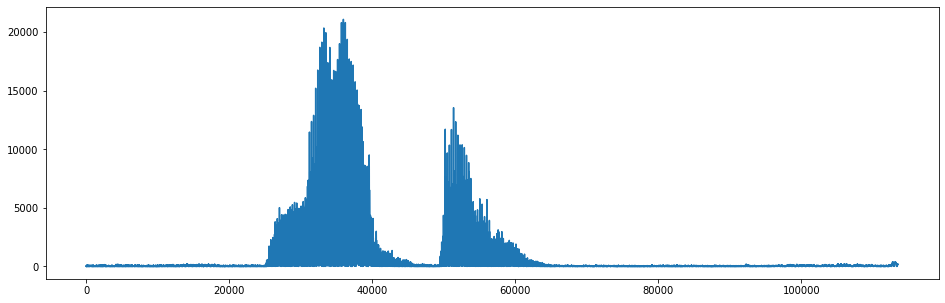

In [202]:
#Plot word Filtered and only positive part

plt.rcParams['figure.figsize'] = 16,5
#plot(audio1,'r')
plt.plot(np.absolute(word_filt))

#  Segment Word

Do the first segmentation in order to isolate the desired word

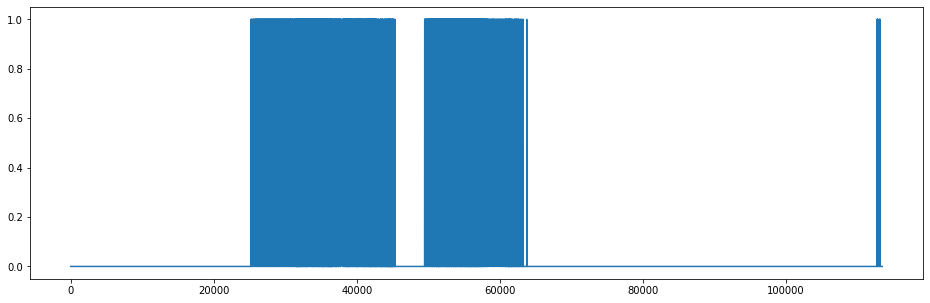

In [203]:
#Apply Threshold for the word phonems

results = [1 if item > 0.001*1e8 else 0 for item in word_filt**2]
plt.plot(results)

# of chunks detected: 2
25215 45356
20141


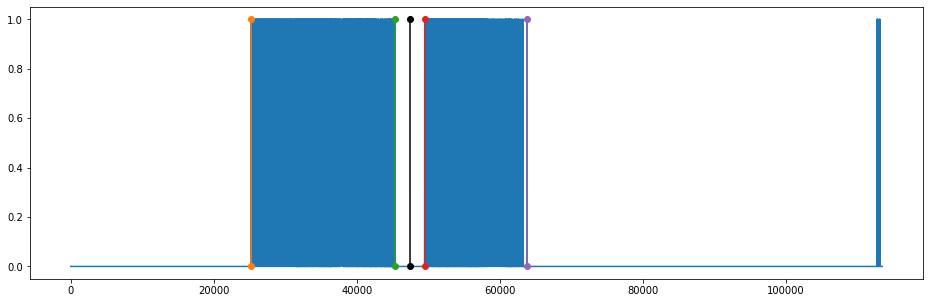

In [204]:
# Variables
x1 = x2 = 0
flag = False
chunks = []
coordinates = []
zeros_list = []
silence_len = 2000
min_len = 5000

plt.plot(results)
for i, result in enumerate(results):
    # First signal rise
    if(flag == False and result == 1 and x1 == 0):
        flag = True
        x1 = i
    # Check if fall is permanent
    if(flag == True):
        if(result == 0):
            zeros_list.append(result)
        else:
            zeros_list = []
    # Signal fall
    if(flag == True and len(zeros_list) >= silence_len and x2 == 0):
        flag = False
        x2 = i - len(zeros_list)
        # If data is valid, save it in list
        if(not x2-x1 <= min_len):
            chunks.append(results[x1:x2+1])
            coordinates.append([x1, x2])
            plt.plot([x1, x1], [0, 1], [x2, x2], [0, 1], marker='o')
        # Reset to initial state
        x1 = x2 = 0

print(f'# of chunks detected: {len(chunks)}')

pt1 = coordinates[0]
try:
    pt2 = coordinates[1]
    div_ptn = ((pt2[0] - pt1[1]) / 2) + pt1[1]
except:
    div_ptn = ((pt1[1] + pt1[0]) / 2)
    
# Draw dividing line
plt.plot([div_ptn, div_ptn], [0, 1], marker='o', color="black")
print(pt1[0], pt1[1])
print(pt1[1] - pt1[0])

# Split Word

Split the word in two phonemes

In [205]:
#Make segmentation point integer
div_ptn = round(div_ptn)

# Fix-sized segmentation (breaks a signal into non-overlapping segments)
signal = word / (2**15)
signal_len = len(signal)
segment_size_t = 1 # segment size in seconds
segment_size = segment_size_t * fs  # segment size in samples

# Break signal into list of segments in a single-line Python code
segment1 = word[:div_ptn]
segment2 = word[div_ptn:]
segments = [segment1, segment2]

# Find out the number of Segments
n = len(segments)

# Acess the first chunk of the audio
samples = segments[0]

# Process each chunk
# Save each segment in a seperate filename
for iS, s in enumerate(segments):
    write('Word Detection/WD_data/'+filename+'_{0:d}.wav'.format(segment_size_t * iS, segment_size_t * (iS + 1)), fs, (s))

# MFCC's

In [215]:
#First phoneme "_0.wav" / Second Phoneme "_1.wav"

directory = 'Word Detection/WD_data/' + filename + '_1.wav'

#Load phoneme with librosa
phoneme1, fs = librosa.load(directory, sr=44100)

#Calculate MFCC'S
mfccs = librosa.feature.mfcc(phoneme1, sr=fs, n_mfcc=42, n_fft = 1024, hop_length = 50,
                                n_mels = 1000,  fmin = 10, fmax = 4000)

#Normalize MFCC's Results (Y axis)
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)

#Play Audio
ipd.Audio(phoneme1,rate=fs)

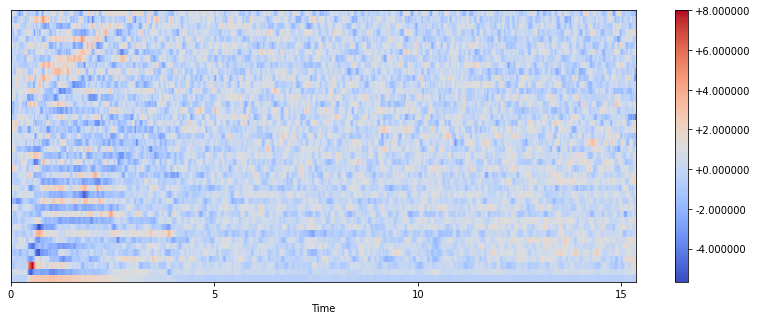

In [216]:
#Visualize MFCC 
plt.figure(figsize=(14,5))
sr = fs
librosa.display.specshow(mfccs,x_axis='time',sr=sr)
plt.colorbar(format="%+2f")
plt.show()

# Training and Classificator

## Read and calculate MFCC for all segmented phonemes

In [217]:
def get_mfccs(signal, fs):
    
    #Calculate MFCCs
    mfccs = librosa.feature.mfcc(signal, sr=fs, n_mfcc=200, n_fft = 1024, hop_length = 50, n_mels = 1000,  fmin = 10, fmax = 4000)
    
    # Calculate average
    mfccs = np.average(mfccs, axis=1)
    #mfccs = np.average(np.average(mfccs, axis=1))
    # Make it into a one-dimensional array
    mfccs = mfccs.flatten()
    mfccs = mfccs.tolist()
    return mfccs
    

In [ ]:
#directory = 'C:/Users/lemos/PDS/TP/Word Detection/WD_data/'
directory = 'C:/Users/Dasil/1. Processamento Digital do Sinal/Project/Word Detection/WD_data/'

hope = False
mfcc_data = []
phoneme_list = []

for file in os.listdir(directory):
    # Get audio file
    filename = os.path.join(directory, file)
    
    # load Audio for Signal
    signal, fs = librosa.load(filename, sr = 44100)
    
    # Get mfccs from audio
    mfccs = get_mfccs(signal, fs)
    mfccs.insert(1,mfccs[0])
    #mfccs = mfccs[:18]
        
    #Calculate Cepstrung and Power Spectrum
    #ceps, spec = real_cepstrum(signal, n=None)
    #N = signal.shape[0]

    #Power Specturm
    #power_spec = np.abs(spec[:N//2])**2
    #index = np.where(power_spec == np.max(power_spec))
    #mfccs.append(index[0][0])
    
    #Calculate Zero Cross Rate
    #frameSize = 256
    #overlap = 0
    #zcr = ZCR(signal, frameSize, overlap)
    #mfccs.append(np.max(zcr))

    #Calculate Cepstrum
    #abs_ceps = np.abs(ceps[:N//2])**2
    #mfccs.append(round(np.max(abs_ceps)))        
        
    # Remove the first coeficient
    mfccs.pop(0)

    # Delete the features of some mfcc coeficients because they are not needed.
    #mfccs = mfccs[:12]
    #mfccs = mfccs[25:]
    mfccs = mfccs[:18]
    
    # Insert label
    file = file.replace('.wav', '')
    file_parts = file.split('_')
    word = file_parts[1]
    if (len(word) > 4):
        if(file_parts[-1] == '0'):
            phoneme = word[0:3]
        else:
            phoneme = word[3:]
    else:
        if(file_parts[-1] == '0'):
            phoneme = word[0:2]
        else:
            phoneme = word[2:]
    phoneme_list.append(phoneme)
    mfccs.insert(0, phoneme)
    mfcc_data.append(mfccs) 
    
# Remove duplicates
phoneme_list = list(dict.fromkeys(phoneme_list))
print(f'Phonemes: {phoneme_list}')
print(f'# of phonemes: {len(phoneme_list)}')

# Loading the Dataset

In [250]:
# Dataset loading
df = pd.DataFrame(mfcc_data)

x = df.iloc[:,1:] # MFCC features
y = df.iloc[:,0] # Phoneme label

# Label changed to number once
label = set(y)
label_list = list(label)
label_list.sort()
for i in range(len(label_list)):
    y[y == label_list[i]] = i
y = np.array(y, dtype = "int")

# Preview dataframe
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,-1333.824829,-13.344981,-8.673552,16.886024,-21.717295,-6.735435,7.127103,-9.960970,13.504705,-24.204016,0.162556,-5.730914,-3.007067,-9.956505,6.730868,-13.654622,3.832473,-3.653511
1,6,-2047.637817,41.290699,2.112942,17.034643,-3.494052,4.061397,-2.206772,4.460487,8.158010,-8.500338,2.002730,3.357300,-2.801673,1.526366,-1.395955,-0.560099,-0.096373,-3.564867
2,0,-1358.306396,-27.451931,1.506319,11.318576,-17.887531,0.313432,3.328127,-7.138087,9.887049,-14.652740,5.700831,-11.412127,4.718484,-9.180216,5.071042,-9.899351,2.345407,-1.999251
3,6,-1522.450317,34.833778,-13.227207,15.833639,-12.494040,-1.964486,-1.604259,-0.622769,11.451959,-15.049759,1.468158,0.493478,-2.819326,-2.246803,0.000085,-4.346762,1.448318,-2.369789
4,0,-1430.136230,-18.182390,34.160870,23.533379,-23.276001,-13.209202,7.364529,-23.842701,7.921567,-14.682115,13.051703,-13.635929,6.975810,-6.515664,-11.448876,-3.455009,-10.726481,0.381645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,9,-1713.436035,-14.930456,28.081966,-3.269842,22.599226,-7.594925,-0.150675,12.487407,-0.331729,2.393736,-0.333911,3.020628,-2.268018,-1.279858,2.308494,-1.566175,-2.876453,2.377063
1140,7,-1679.615601,-61.792160,66.527222,-16.308260,26.346516,-12.518517,3.860537,-1.688408,-0.341534,-0.289854,-1.569777,4.417487,-5.646485,3.351714,-2.117579,-3.489269,-1.272613,-2.289502
1141,9,-1713.436035,-14.930456,28.081966,-3.269842,22.599226,-7.594925,-0.150675,12.487407,-0.331729,2.393736,-0.333911,3.020628,-2.268018,-1.279858,2.308494,-1.566175,-2.876453,2.377063
1142,7,-1739.948364,-48.406658,67.691559,-15.592954,23.433620,-7.664473,2.089020,-2.396087,5.130900,-1.910935,0.549396,5.342144,-4.116349,3.726255,-0.397541,-6.060598,3.774299,-6.489661


# Train the classifier

In [252]:
# Determine the train data and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)
#print(f'Train: {x_train.shape}\nTest: {x_test.shape}\n')

# Data standardization
sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

# Instantiate an SVM
model_linear = SVC(kernel='linear', random_state=1)
model_poly = SVC(kernel='poly', random_state= 1)
model_rbf = SVC(kernel='rbf', random_state=1)
model_knn = KNeighborsClassifier(n_neighbors=5)
# Fit models
model_linear.fit(x_train_std, y_train)
model_poly.fit(x_train_std, y_train)
model_rbf.fit(x_train_std, y_train)
model_knn.fit(x_train_std, y_train)

# ===== Train data =====
# Predictions
pred_linear_train = model_linear.predict(x_train_std)
pred_poly_train = model_poly.predict(x_train_std)
pred_rbf_train = model_rbf.predict(x_train_std)
pred_knn_train = model_knn.predict(x_train_std)
# Accuracy scores
accuracy_linear_train = accuracy_score(y_train, pred_linear_train)
accuracy_poly_train = accuracy_score(y_train, pred_poly_train)
accuracy_rbf_train = accuracy_score(y_train, pred_rbf_train)
accuracy_knn_train = accuracy_score(y_train, pred_knn_train)

#print('Train result')
#print(f'Linear : {int(accuracy_linear_train*100)}%')
#print(f'Poly : {int(accuracy_poly_train*100)}%')
#print(f'RBF : {int(accuracy_rbf_train*100)}%')
#print("-" * 15)

# ===== Test data =====
# Predictions
pred_linear_test = model_linear.predict(x_test_std)
pred_poly_test = model_poly.predict(x_test_std)
pred_rbf_test = model_rbf.predict(x_test_std)
pred_knn_test = model_knn.predict(x_test_std)
# Accuracy scores
accuracy_linear_test = accuracy_score(y_test, pred_linear_test)
accuracy_poly_test = accuracy_score(y_test, pred_poly_test)
accuracy_rbf_test = accuracy_score(y_test, pred_rbf_test)
accuracy_knn_test = accuracy_score(y_test, pred_knn_test)

#print('Test result')
#print(f'Linear : {int(accuracy_linear_test*100)}%')
#print(f'Poly : {int(accuracy_poly_test*100)}%')
#print(f'RBF : {int(accuracy_rbf_test*100)}%')

# Create dataframe
data = {'Train result':[accuracy_linear_train*100, accuracy_poly_train*100, accuracy_rbf_train*100, accuracy_knn_train*100],
        'Test result': [accuracy_linear_test*100, accuracy_poly_test*100, accuracy_rbf_test*100, accuracy_knn_test*100]}
df_results = pd.DataFrame(data)
# Change the row indexes
df_results.index = ['Linear', 'Poly', 'RBF', 'KNN']
df_results.round(decimals=2)

,Train result,Test result
Linear,80.33,68.56
Poly,76.28,61.14
RBF,85.14,74.67
KNN,83.28,64.19


# Confusion Matrix 

## Linear Confusion Matrix

In [221]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, pred_linear_test)
df_cm = pd.DataFrame(cm, columns=phoneme_list)
df_cm

,ca,pa,sa,ta,ve,cha,chu,va,far,da,la,ri
0,18,2,0,0,1,1,0,0,0,7,0,0
1,4,15,0,0,0,0,1,0,0,0,0,0
2,2,0,15,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0,4,0,0
4,4,0,0,0,16,1,2,0,0,1,0,0
5,2,0,0,0,1,8,1,1,0,0,0,0
6,1,0,0,0,0,0,25,0,0,1,0,0
7,1,0,0,0,0,1,0,19,0,0,0,0
8,1,2,0,0,1,0,1,0,1,3,0,0
9,2,1,0,1,1,1,6,0,0,22,0,2


## Poly Confusion Matrix

In [222]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, pred_poly_test)
df_cm = pd.DataFrame(cm, columns=phoneme_list)
df_cm

,ca,pa,sa,ta,ve,cha,chu,va,far,da,la,ri
0,13,0,1,0,0,0,0,0,0,14,0,1
1,0,13,1,0,0,0,1,0,0,5,0,0
2,0,0,13,0,0,0,0,1,0,3,0,0
3,1,0,0,0,0,0,0,0,0,4,1,0
4,2,1,0,0,10,0,1,0,0,10,0,0
5,0,1,0,0,0,9,0,0,0,3,0,0
6,0,0,0,0,0,0,20,0,0,7,0,0
7,0,0,0,0,0,0,0,18,0,3,0,0
8,0,0,0,0,0,1,0,0,2,6,0,0
9,2,0,0,1,0,0,3,0,0,30,0,0


## RBF Confusion Matrix

In [223]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, pred_rbf_test)
df_cm = pd.DataFrame(cm, columns=phoneme_list)
df_cm

,ca,pa,sa,ta,ve,cha,chu,va,far,da,la,ri
0,18,0,1,0,2,1,0,0,0,7,0,0
1,1,19,0,0,0,0,0,0,0,0,0,0
2,1,0,15,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,4,0,1
4,3,2,0,0,18,0,0,0,0,1,0,0
5,0,0,0,0,1,9,0,1,0,2,0,0
6,0,0,0,0,0,0,27,0,0,0,0,0
7,0,0,1,0,0,0,0,20,0,0,0,0
8,0,0,0,0,0,1,0,0,3,5,0,0
9,1,0,0,0,1,0,6,0,0,27,0,1


## KNN Confusion Matrix

In [224]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, pred_knn_test)
df_cm = pd.DataFrame(cm, columns=phoneme_list)
df_cm

,ca,pa,sa,ta,ve,cha,chu,va,far,da,la,ri
0,19,0,1,1,0,0,2,0,1,5,0,0
1,2,13,0,0,1,3,1,0,0,0,0,0
2,0,1,14,0,0,1,0,0,0,0,0,1
3,0,0,0,2,0,0,1,0,0,2,0,1
4,7,1,0,0,13,0,1,0,0,2,0,0
5,0,0,0,2,0,8,0,2,0,1,0,0
6,0,0,0,0,0,0,24,0,0,3,0,0
7,0,0,2,0,0,0,0,19,0,0,0,0
8,0,0,0,2,0,0,1,0,2,4,0,0
9,3,0,0,1,2,1,8,0,1,20,0,0


# Single Validation Test

In [238]:
#Directorio do Projeto (Escrever o directório do projeto)
os.chdir(r'C:\Users\Dasil\1. Processamento Digital do Sinal\Project')
#os.chdir(r'C:/Users/lemos/PDS/TP/')

#Chose the file of test
file = 'N_chata_02'

#Load the phonemes
phoneme1 = f'Word Detection/WD_data/{file}_0.wav' 
phoneme2 = f'Word Detection/WD_data/{file}_1.wav'

# load Audio for Signal
signal_phoneme1, fs = librosa.load(phoneme1)
signal_phoneme2, fs = librosa.load(phoneme2)

#Calculate MFCCs
mfccs_phoneme1 = get_mfccs(signal_phoneme1, fs)
mfccs_phoneme2 = get_mfccs(signal_phoneme2, fs)

mfccs_phoneme1.pop(0)
mfccs_phoneme2.pop(0)
mfccs_phoneme1 = mfccs_phoneme1[:18]
mfccs_phoneme2 = mfccs_phoneme2[:18]

# #Calculate Cepstrung and Power Spectrum
# ceps1, spec1 = real_cepstrum(signal_phoneme1, n=None)
# N1 = signal_phoneme1.shape[0]
# ceps2, spec2 = real_cepstrum(signal_phoneme2, n=None)
# N2 = signal_phoneme2.shape[0]

# #Power Specturm
# power_spec1 = np.abs(spec1[:N//2])**2
# index1 = np.where(power_spec1 == np.max(power_spec1))
# mfccs_phoneme1.append(index1[0][0])

# power_spec2 = np.abs(spec2[:N//2])**2
# index2 = np.where(power_spec2 == np.max(power_spec2))
# mfccs_phoneme2.append(index2[0][0])

# #Calculate Zero Cross Rate
# frameSize = 256
# overlap = 0
# zcr1 = ZCR(signal_phoneme1, frameSize, overlap)
# mfccs_phoneme1.append(np.max(zcr1))

# zcr2 = ZCR(signal_phoneme2, frameSize, overlap)
# mfccs_phoneme2.append(np.max(zcr2))

# #Calculate Cepstrum
# abs_ceps1 = np.abs(ceps1[:N//2])**2
# mfccs_phoneme1.append(round(np.max(abs_ceps1)))

# abs_ceps2 = np.abs(ceps2[:N//2])**2
# mfccs_phoneme2.append(round(np.max(abs_ceps2)))


df_phoneme1 = pd.DataFrame(mfccs_phoneme1).T
df_phoneme2 = pd.DataFrame(mfccs_phoneme2).T

# Data standardization
x_std_phoneme1 = sc.transform(df_phoneme1)
x_std_phoneme2 = sc.transform(df_phoneme2)

# Predict 1st phoneme
pred_linear_phoneme1 = model_linear.predict(x_std_phoneme1)
pred_poly_phoneme1 = model_poly.predict(x_std_phoneme1)
pred_rbf_phoneme1 = model_rbf.predict(x_std_phoneme1)
pred_knn_phoneme1 = model_knn.predict(x_std_phoneme1)

# Predict 2nd phoneme
pred_linear_phoneme2 = model_linear.predict(x_std_phoneme2)
pred_poly_phoneme2 = model_poly.predict(x_std_phoneme2)
pred_rbf_phoneme2 = model_rbf.predict(x_std_phoneme2)
pred_knn_phoneme2 = model_knn.predict(x_std_phoneme2)

data = {'Linear':[phoneme_list[int(pred_linear_phoneme1)]+phoneme_list[int(pred_linear_phoneme2)]],
        'Poly':[phoneme_list[int(pred_poly_phoneme1)]+phoneme_list[int(pred_linear_phoneme2)]],
        'RBF': [phoneme_list[int(pred_rbf_phoneme1)]+phoneme_list[int(pred_linear_phoneme2)]],
        'KNN': [phoneme_list[int(pred_knn_phoneme1)]+phoneme_list[int(pred_linear_phoneme2)]]}

df_models = pd.DataFrame(data)
df_models

,Linear,Poly,RBF,KNN
0,lachu,richu,pachu,sachu


#  Phoneme Sucess Test

In [245]:
#Directorio do Projeto (Escrever o directório do projeto)
os.chdir(r'C:\Users\Dasil\1. Processamento Digital do Sinal\Project')
#os.chdir(r'C:/Users/lemos/PDS/TP/')


directory = 'Word Detection/WD_data/'

linear_t = linear_f = 0
poly_t = poly_f = 0
rbf_t = rbf_f = 0
knn_t = knn_f = 0

for file in os.listdir(directory):
    
    path_phoneme1 = os.path.join(directory, file)
    path_phoneme2 = os.path.join(directory, file)

    # Load Audio for Signal
    signal_phoneme1, fs = librosa.load(path_phoneme1)
    signal_phoneme2, fs = librosa.load(path_phoneme2)

    # Calculate MFCCs
    mfccs_phoneme1 = get_mfccs(signal_phoneme1, fs)
    mfccs_phoneme2 = get_mfccs(signal_phoneme2, fs)
    
    # Remove first coeficient
    mfccs_phoneme1.pop(0)
    mfccs_phoneme2.pop(0)
    
    # Select the first 18 coeficients
    mfccs_phoneme1 = mfccs_phoneme1[:18]
    mfccs_phoneme2 = mfccs_phoneme2[:18]

    # Create dataframe
    df_phoneme1 = pd.DataFrame(mfccs_phoneme1).T
    df_phoneme2 = pd.DataFrame(mfccs_phoneme2).T

    # Data standardization
    x_std_phoneme1 = sc.transform(df_phoneme1)
    x_std_phoneme2 = sc.transform(df_phoneme2)

    # Predict 1st phoneme
    pred_linear_phoneme1 = model_linear.predict(x_std_phoneme1)
    pred_poly_phoneme1 = model_poly.predict(x_std_phoneme1)
    pred_rbf_phoneme1 = model_rbf.predict(x_std_phoneme1)
    pred_knn_phoneme1 = model_knn.predict(x_std_phoneme1)

    # Predict 2nd phoneme
    pred_linear_phoneme2 = model_linear.predict(x_std_phoneme2)
    pred_poly_phoneme2 = model_poly.predict(x_std_phoneme2)
    pred_rbf_phoneme2 = model_rbf.predict(x_std_phoneme2)
    pred_knn_phoneme2 = model_knn.predict(x_std_phoneme2)
    
    pred_linear_word = phoneme_list[int(pred_linear_phoneme1)] + phoneme_list[int(pred_linear_phoneme2)]
    pred_poly_word = phoneme_list[int(pred_poly_phoneme1)] + phoneme_list[int(pred_poly_phoneme2)]
    pred_rbf_word = phoneme_list[int(pred_rbf_phoneme1)] + phoneme_list[int(pred_rbf_phoneme2)]
    pred_knn_word = phoneme_list[int(pred_knn_phoneme1)] + phoneme_list[int(pred_knn_phoneme2)]
    
    # Results
    if phoneme_list[int(pred_linear_phoneme1)] in file  or phoneme_list[int(pred_linear_phoneme2)] in file:
        linear_t += 1
    else:
        linear_f += 1
        
    if phoneme_list[int(pred_poly_phoneme1)] in file  or phoneme_list[int(pred_poly_phoneme2)] in file:
        poly_t += 1
    else:
        poly_f += 1
        
    if phoneme_list[int(pred_rbf_phoneme1)] in file  or phoneme_list[int(pred_rbf_phoneme2)] in file:
        rbf_t += 1
    else:
        rbf_f += 1
        
    if phoneme_list[int(pred_knn_phoneme1)] in file  or phoneme_list[int(pred_knn_phoneme2)] in file:
        knn_t += 1
    else:
        knn_f += 1

# Intialise data of lists.
data = {'Model':['Linear', 'Poly', 'RBF', 'KNN'],
        'True':[linear_t, poly_t, rbf_t, knn_t],
        'False':[linear_f, poly_f, rbf_f, knn_f],
        'Success (%)':[(linear_t/(linear_t+linear_f))*100, (poly_t/(poly_t+poly_f))*100, (rbf_t/(rbf_t+rbf_f))*100, (knn_t/(knn_t+knn_f))*100]}

df_models = pd.DataFrame(data)
df_models

,Model,True,False,Success (%)
0,Linear,139,1005,12.150350
1,Poly,125,1019,10.926573
2,RBF,360,784,31.468531
3,KNN,174,970,15.209790


# Word Success Test

In [246]:
#Directorio do Projeto (Escrever o directório do projeto)
os.chdir(r'C:\Users\Dasil\1. Processamento Digital do Sinal\Project')
#os.chdir(r'C:/Users/lemos/PDS/TP/')


directory = 'Word Detection/WD_data/'

linear_t = linear_f = 0
poly_t = poly_f = 0
rbf_t = rbf_f = 0
knn_t = knn_f = 0

for file in os.listdir(directory):
    
    path_phoneme1 = os.path.join(directory, file)
    path_phoneme2 = os.path.join(directory, file)

    # Load Audio for Signal
    signal_phoneme1, fs = librosa.load(path_phoneme1)
    signal_phoneme2, fs = librosa.load(path_phoneme2)

    # Calculate MFCCs
    mfccs_phoneme1 = get_mfccs(signal_phoneme1, fs)
    mfccs_phoneme2 = get_mfccs(signal_phoneme2, fs)
    
    # Remove first coeficient
    mfccs_phoneme1.pop(0)
    mfccs_phoneme2.pop(0)
    
    # Select the first 18 coeficients
    mfccs_phoneme1 = mfccs_phoneme1[:18]
    mfccs_phoneme2 = mfccs_phoneme2[:18]

    # Create dataframe
    df_phoneme1 = pd.DataFrame(mfccs_phoneme1).T
    df_phoneme2 = pd.DataFrame(mfccs_phoneme2).T

    # Data standardization
    x_std_phoneme1 = sc.transform(df_phoneme1)
    x_std_phoneme2 = sc.transform(df_phoneme2)

    # Predict 1st phoneme
    pred_linear_phoneme1 = model_linear.predict(x_std_phoneme1)
    pred_poly_phoneme1 = model_poly.predict(x_std_phoneme1)
    pred_rbf_phoneme1 = model_rbf.predict(x_std_phoneme1)
    pred_knn_phoneme1 = model_knn.predict(x_std_phoneme1)

    # Predict 2nd phoneme
    pred_linear_phoneme2 = model_linear.predict(x_std_phoneme2)
    pred_poly_phoneme2 = model_poly.predict(x_std_phoneme2)
    pred_rbf_phoneme2 = model_rbf.predict(x_std_phoneme2)
    pred_knn_phoneme2 = model_knn.predict(x_std_phoneme2)
    
    pred_linear_word = phoneme_list[int(pred_linear_phoneme1)] + phoneme_list[int(pred_linear_phoneme2)]
    pred_poly_word = phoneme_list[int(pred_poly_phoneme1)] + phoneme_list[int(pred_poly_phoneme2)]
    pred_rbf_word = phoneme_list[int(pred_rbf_phoneme1)] + phoneme_list[int(pred_rbf_phoneme2)]
    pred_knn_word = phoneme_list[int(pred_knn_phoneme1)] + phoneme_list[int(pred_knn_phoneme2)]
    
    # Results
    if pred_linear_word in file:
        linear_t += 1
    else:
        linear_f += 1
        
    if pred_poly_word in file:
        poly_t += 1
    else:
        poly_f += 1
        
    if pred_rbf_word in file:
        rbf_t += 1
    else:
        rbf_f += 1
        
    if pred_knn_word in file:
        knn_t += 1
    else:
        knn_f += 1

# Intialise data of lists.
data = {'Model':['Linear', 'Poly', 'RBF', 'KNN'],
        'True':[linear_t, poly_t, rbf_t, knn_t],
        'False':[linear_f, poly_f, rbf_f, knn_f],
        'Success (%)':[(linear_t/(linear_t+linear_f))*100, (poly_t/(poly_t+poly_f))*100, (rbf_t/(rbf_t+rbf_f))*100, (knn_t/(knn_t+knn_f))*100]}

df_models = pd.DataFrame(data)
df_models

,Model,True,False,Success (%)
0,Linear,0,1144,0.0
1,Poly,0,1144,0.0
2,RBF,0,1144,0.0
3,KNN,0,1144,0.0
